In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from itertools import cycle

In [54]:
# Load the dataset
data = pd.read_csv('/content/mental-health-apprehensions-cleaned.csv')

# Display the first few rows of the dataset
data.head()

,EVENT_UNIQUE_ID,REPORT_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DOW,Day_of_Year,REPORT_DAY,REPORT_HOUR,OCC_DATE,OCC_YEAR,...,DIVISION,PREMISES_TYPE,APPREHENSION_TYPE,SEX,AGE_COHORT,Neighbourhood_158,NEIGHBOURHOOD_158,Neighbourhood_140,NEIGHBOURHOOD_140,REPORT_DATE_COMBINED
0,GO-20141263946,01-01-2014,2014,January,Wednesday,1,1,19,01-01-2014,2014,...,D42,House,Mha Sec 17 (Power Of App),Male,55-64,144,Morningside Heights,131,Rouge (131),01-Jan-14
1,GO-20141261121,01-01-2014,2014,January,Wednesday,1,1,5,01-01-2014,2014,...,D14,Apartment,Mha Sec 17 (Power Of App),Female,25-34,78,Kensington-Chinatown,78,Kensington-Chinatown (78),01-Jan-14
2,GO-20141261310,01-01-2014,2014,January,Wednesday,1,1,8,01-01-2014,2014,...,Not Specified,Outside,Mha Sec 17 (Power Of App),Female,55-64,NSA,NSA,NSA,NSA,01-Jan-14
3,GO-20141263993,01-01-2014,2014,January,Wednesday,1,1,19,01-01-2014,2014,...,D12,Apartment,Mha Sec 17 (Power Of App),Male,18 to 24,115,Mount Dennis,115,Mount Dennis (115),01-Jan-14
4,GO-20141262098,01-01-2014,2014,January,Wednesday,1,1,11,01-01-2014,2014,...,D11,House,Mha Sec 17 (Power Of App),Male,25-34,91,Weston-Pelham Park,91,Weston-Pellam Park (91),01-Jan-14


In [55]:
# Basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22813 entries, 0 to 22812
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   EVENT_UNIQUE_ID       22813 non-null  object 
 1   REPORT_DATE           22813 non-null  object 
 2   REPORT_YEAR           22813 non-null  int64  
 3   REPORT_MONTH          22813 non-null  object 
 4   REPORT_DOW            22813 non-null  object 
 5   Day_of_Year           22813 non-null  int64  
 6   REPORT_DAY            22813 non-null  int64  
 7   REPORT_HOUR           22813 non-null  int64  
 8   OCC_DATE              22813 non-null  object 
 9   OCC_YEAR              22813 non-null  int64  
 10  OCC_MONTH             22813 non-null  object 
 11  OCC_DOY               22813 non-null  int64  
 12  OCC_DAY               22813 non-null  int64  
 13  OCC_DOW               22813 non-null  object 
 14  OCC_HOUR              22812 non-null  float64
 15  DIVISION           

In [56]:
# Handle missing values (if any)
data = data.dropna()

In [57]:

# Encode categorical variables
label_encoder = LabelEncoder()
data['NEIGHBOURHOOD_158'] = label_encoder.fit_transform(data['NEIGHBOURHOOD_158'])
data['SEX'] = label_encoder.fit_transform(data['SEX'])
data['APPREHENSION_TYPE'] = label_encoder.fit_transform(data['APPREHENSION_TYPE'])
data['PREMISES_TYPE'] = label_encoder.fit_transform(data['PREMISES_TYPE'])
data['AGE_COHORT'] = label_encoder.fit_transform(data['AGE_COHORT'])
data['REPORT_MONTH'] = label_encoder.fit_transform(data['REPORT_MONTH'])
data['REPORT_DOW'] = label_encoder.fit_transform(data['REPORT_DOW'])

# Check if encoding was successful
data.head()

,EVENT_UNIQUE_ID,REPORT_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DOW,Day_of_Year,REPORT_DAY,REPORT_HOUR,OCC_DATE,OCC_YEAR,...,DIVISION,PREMISES_TYPE,APPREHENSION_TYPE,SEX,AGE_COHORT,Neighbourhood_158,NEIGHBOURHOOD_158,Neighbourhood_140,NEIGHBOURHOOD_140,REPORT_DATE_COMBINED
0,GO-20141263946,01-01-2014,2014,4,6,1,1,19,01-01-2014,2014,...,D42,3,2,1,4,144,92,131,Rouge (131),01-Jan-14
1,GO-20141261121,01-01-2014,2014,4,6,1,1,5,01-01-2014,2014,...,D14,0,2,0,1,78,74,78,Kensington-Chinatown (78),01-Jan-14
2,GO-20141261310,01-01-2014,2014,4,6,1,1,8,01-01-2014,2014,...,Not Specified,5,2,0,4,NSA,97,NSA,NSA,01-Jan-14
3,GO-20141263993,01-01-2014,2014,4,6,1,1,19,01-01-2014,2014,...,D12,0,2,1,0,115,94,115,Mount Dennis (115),01-Jan-14
4,GO-20141262098,01-01-2014,2014,4,6,1,1,11,01-01-2014,2014,...,D11,3,2,1,1,91,145,91,Weston-Pellam Park (91),01-Jan-14


In [58]:
# Feature variables and target variable
features = ['NEIGHBOURHOOD_158', 'SEX', 'AGE_COHORT', 'REPORT_MONTH', 'REPORT_DOW']
X = data[features]
y = data['APPREHENSION_TYPE']

# Binarize the output for multiclass ROC
y_bin = label_binarize(y, classes=list(range(len(data['APPREHENSION_TYPE'].unique()))))

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

In [59]:
# Initialize the Random Forest Classifier with One-vs-Rest strategy
rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))

# Train the model
rfc.fit(X_train, y_train)

# Make predictions
y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)

In [60]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(y_bin.shape[1])])

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n {report}')

Accuracy: 0.690554459785229
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.20      0.09      0.13       464
     Class 1       0.18      0.05      0.08       324
     Class 2       0.81      0.86      0.83      3579
     Class 3       0.33      0.13      0.19        60
     Class 4       0.20      0.07      0.10       136

   micro avg       0.75      0.69      0.72      4563
   macro avg       0.35      0.24      0.27      4563
weighted avg       0.68      0.69      0.68      4563
 samples avg       0.69      0.69      0.69      4563



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


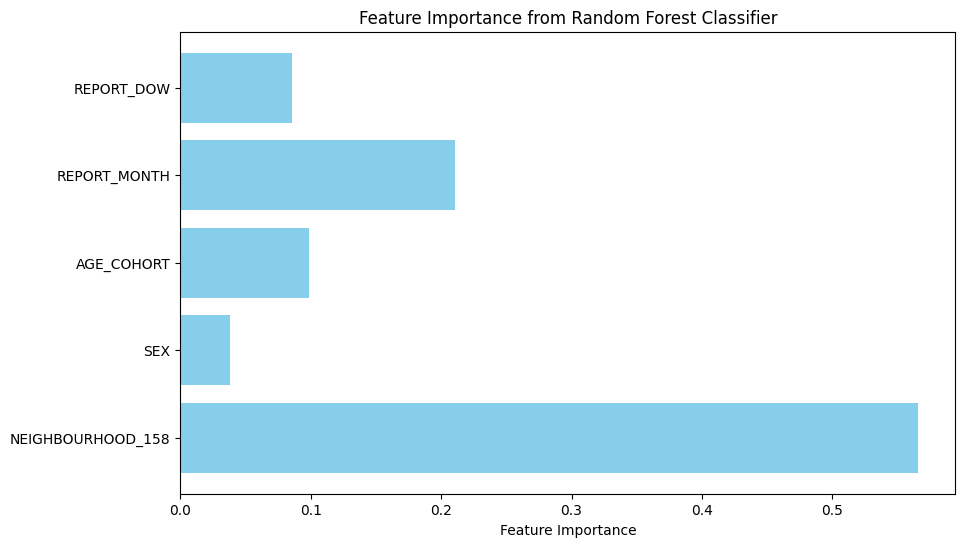

In [61]:
# Feature importance
feature_importances = rfc.estimators_[0].feature_importances_  # Using the first estimator for feature importances
feature_names = features

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()

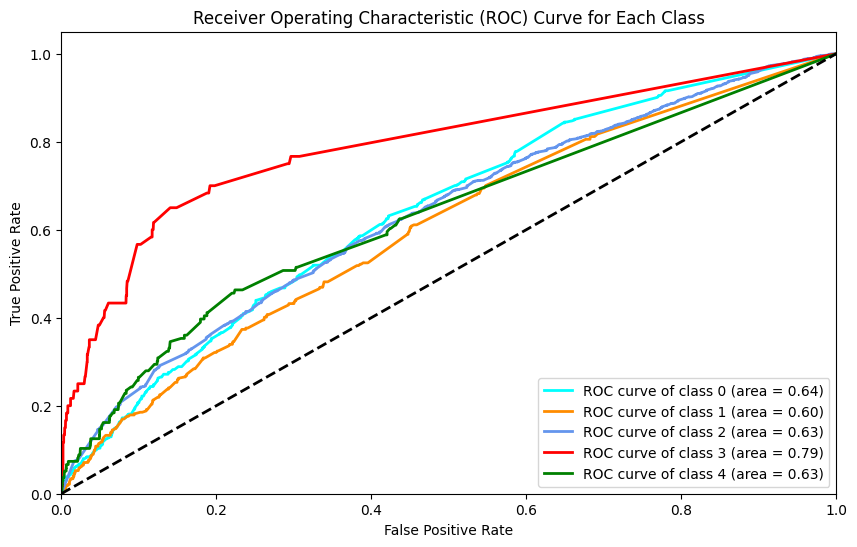

In [64]:
# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

In [65]:
feature_importances = rfc.estimators_[0].feature_importances_  # Using the first estimator for feature importances

In [66]:
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

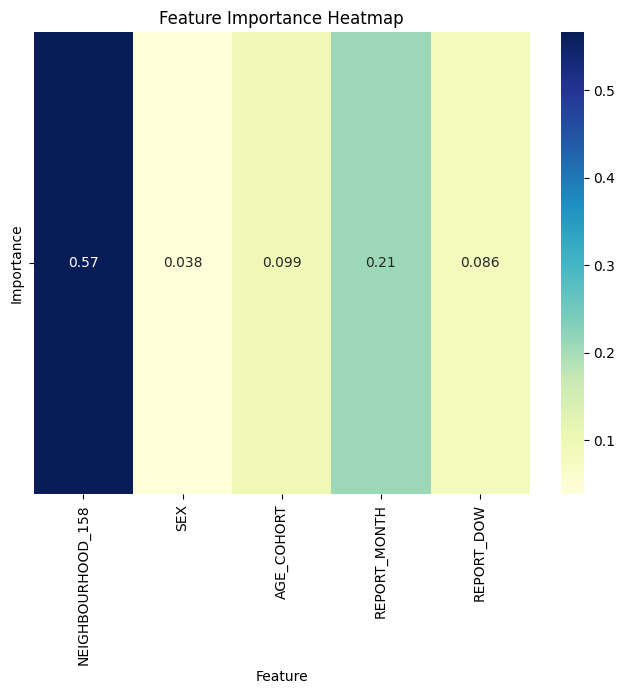

In [68]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(importance_df.set_index('Feature').T, annot=True, cmap='YlGnBu')
plt.title('Feature Importance Heatmap')
plt.show()